# Wine

In [2]:
from SVC import SVC
from ucimlrepo import fetch_ucirepo 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, normalized_mutual_info_score, davies_bouldin_score, rand_score, homogeneity_score, completeness_score,v_measure_score, fowlkes_mallows_score
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram
import pandas as pd


c:\Users\gabri\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [3]:
# fetch dataset 
wine = fetch_ucirepo(id=109) 
  
# data (as pandas dataframes) 
data_wine = wine.data.features.values 
data_wine_scaled = StandardScaler().fit_transform(data_wine)
targets = wine.data.targets 

X_PCA = PCA(n_components=2).fit_transform(data_wine_scaled)

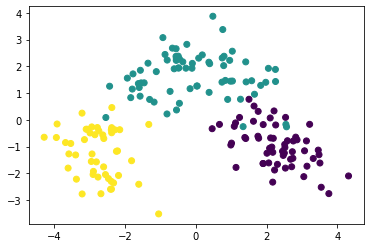

In [4]:
### Visualize dataset on PCA axis
plt.scatter(X_PCA[:,0], X_PCA[:,1], c=targets['class'].to_numpy())

100%|██████████| 178/178 [00:01<00:00, 94.78it/s] 


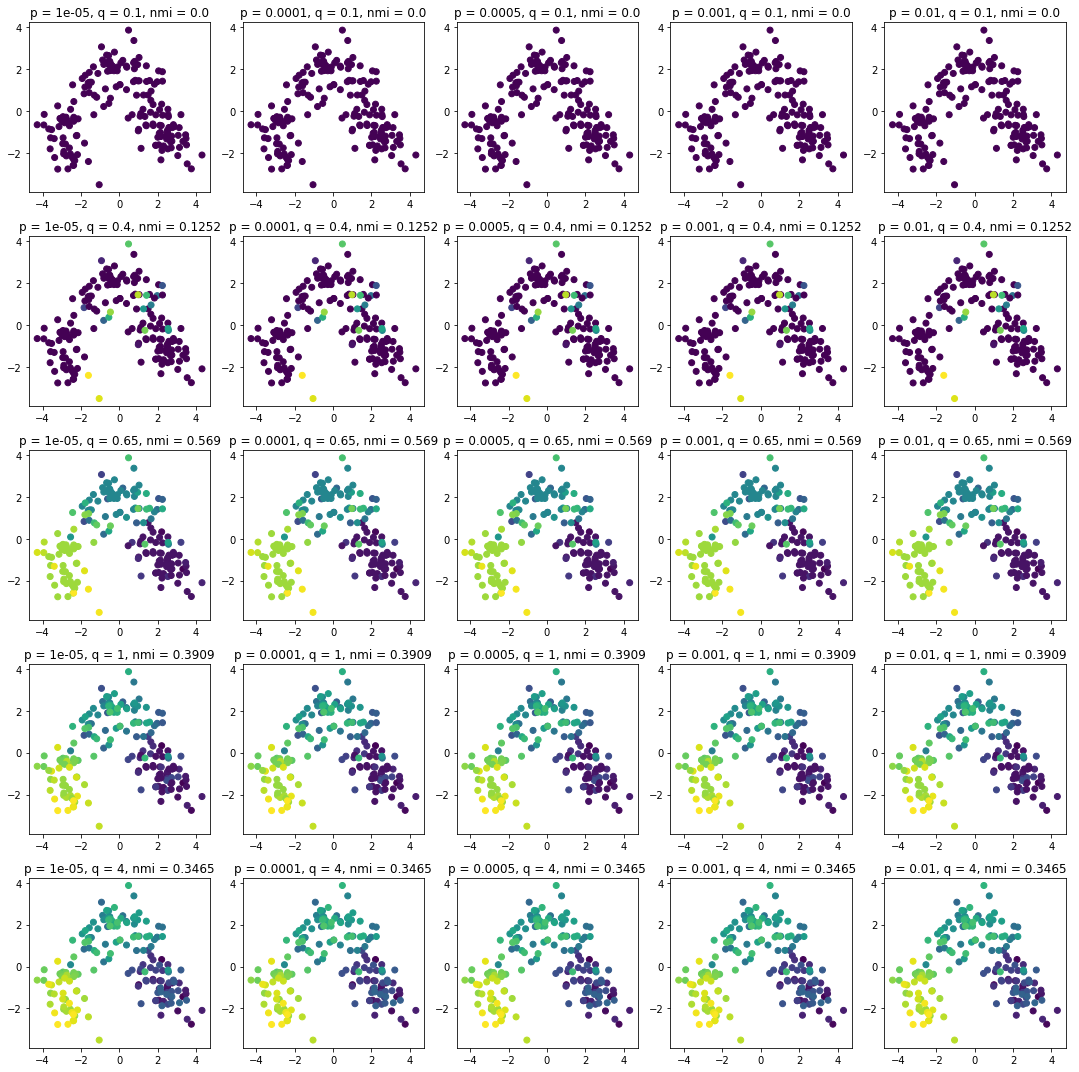

In [5]:
### Exemple of the grid search for the SVC, optimal q is 0.65
l_q = [.1,.4,.65,1,4]
l_p = [1e-5,1e-4,5e-4,1e-3,1e-2]

fig, ax = plt.subplots(len(l_q),len(l_p),figsize=(15,15))

for i,q in enumerate(l_q):
    for j,p in enumerate(l_p):
        labels = SVC(data_wine_scaled, p, q)[0]
        nmi_score = normalized_mutual_info_score(targets['class'].to_numpy(), labels)
        ax[i][j].scatter(X_PCA[:, 0], X_PCA[:, 1], c=labels)
        ax[i][j].set_title('p = {}, q = {}, nmi = {}'.format(p,q,round(nmi_score,4)))

plt.tight_layout()
plt.show()

c:\Users\gabri\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\gabri\anaconda3\lib\site-packages\threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
c:\Users\gabri\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available thread

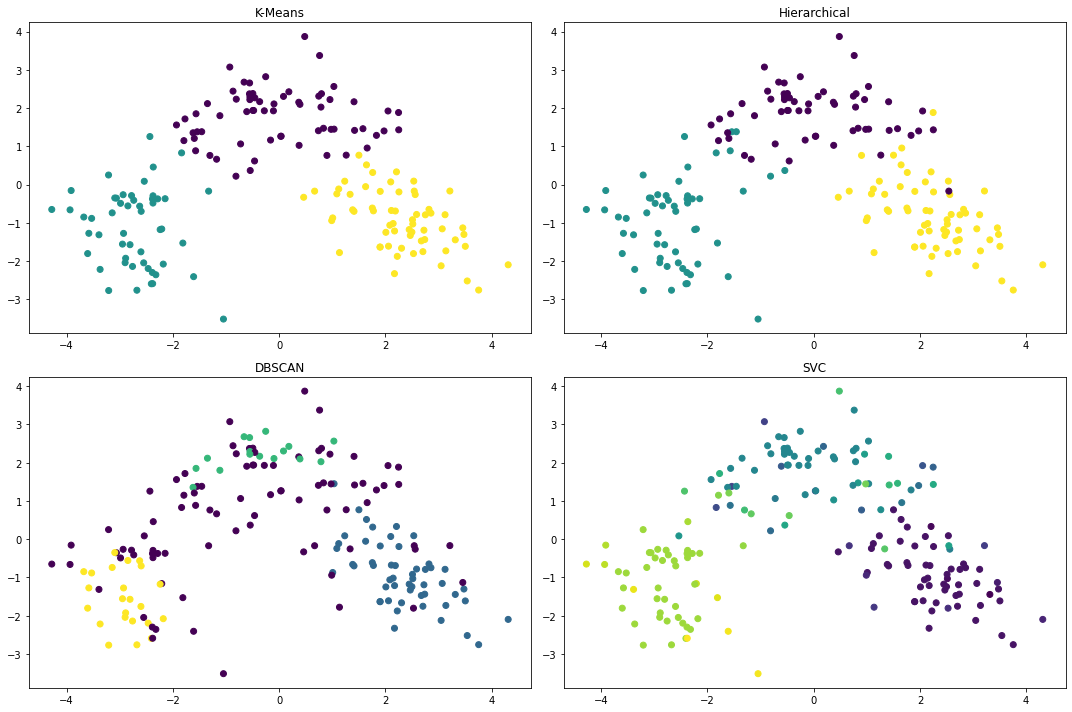

In [6]:
# Define clustering algorithms
kmeans = KMeans(n_clusters=3, random_state=42)
hierarchical = AgglomerativeClustering(n_clusters=3)
dbscan = DBSCAN(eps=2.4, min_samples=17)

algorithms = [kmeans, hierarchical, dbscan, None]
algorithm_names = ['K-Means', 'Hierarchical', 'DBSCAN','SVC']

# Visualize clustering results
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

silhouette = []
nmi = []
dbi = []
rand = []
homogeneity = []
completeness = []
#v_measure = []
fowlkes_mallows = []

for i, algorithm in enumerate(algorithms):
    # Fit the algorithm
    if algorithm is not None:
        labels = algorithm.fit_predict(data_wine_scaled)
    else:
        labels = SVC(data_wine_scaled, 1e-6, 0.65)[0]
    # Calculate the scores
    silhouette.append(round(silhouette_score(data_wine_scaled, labels), 5))
    nmi.append(round(normalized_mutual_info_score(targets['class'].to_numpy(), labels), 5))
    dbi.append(round(davies_bouldin_score(data_wine_scaled, labels), 5))
    rand.append(round(rand_score(targets['class'].to_numpy(), labels), 5))
    homogeneity.append(round(homogeneity_score(targets['class'].to_numpy(), labels), 5))
    completeness.append(round(completeness_score(targets['class'].to_numpy(), labels), 5))
    #v_measure.append(round(v_measure_score(targets['class'].to_numpy(), labels), 5))
    fowlkes_mallows.append(round(fowlkes_mallows_score(targets['class'].to_numpy(), labels), 5))
    # Plot the clusters
    ax[i//2][i%2].scatter(X_PCA[:, 0], X_PCA[:, 1], c=labels)
    ax[i//2][i%2].set_title(algorithm_names[i])

# Put the scores in a DataFrame
scores = pd.DataFrame({
    'Silhouette': silhouette,
    'NMI': nmi,
    'DBI': dbi,
    'Rand': rand,
    'Homogeneity': homogeneity,
    'Completeness': completeness,
    #'V-measure': v_measure,
    'Fowlkes-Mallows': fowlkes_mallows},
    index=algorithm_names)

# Save the scores
#scores.to_csv('C:/Users/gabri/x/4A/Dataset/scores.csv')

# Show the plot
plt.tight_layout()
plt.show()

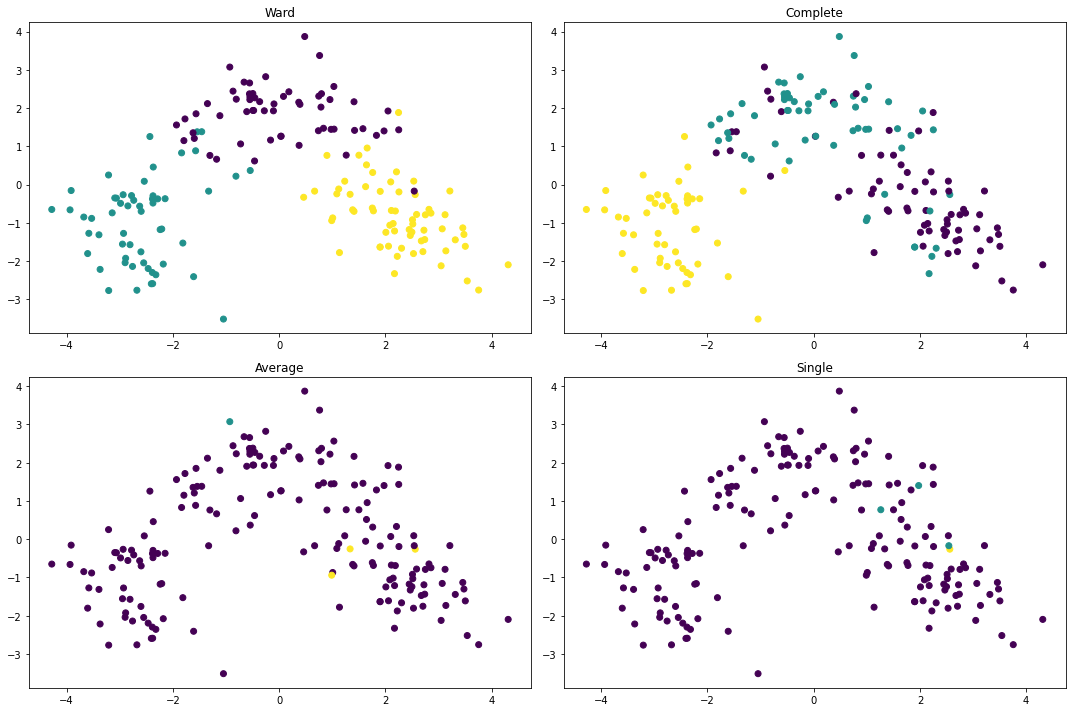

In [7]:
### Compare the different linkages for hierarchical clustering

fig, ax = plt.subplots(2, 2, figsize=(15, 10))

ward = AgglomerativeClustering(n_clusters=3, linkage='ward')
complete = AgglomerativeClustering(n_clusters=3, linkage='complete')
average = AgglomerativeClustering(n_clusters=3, linkage='average')
single = AgglomerativeClustering(n_clusters=3, linkage='single')

linkage_algorithms = [ward, complete, average, single]
linkage_names = ['Ward', 'Complete', 'Average', 'Single']

for i, algorithm in enumerate(linkage_algorithms):
    # Fit the algorithm
    labels = algorithm.fit_predict(data_wine_scaled)
    # Plot the clusters
    ax[i//2][i%2].scatter(X_PCA[:, 0], X_PCA[:, 1], c=labels)
    ax[i//2][i%2].set_title(linkage_names[i])

plt.tight_layout()
plt.show()

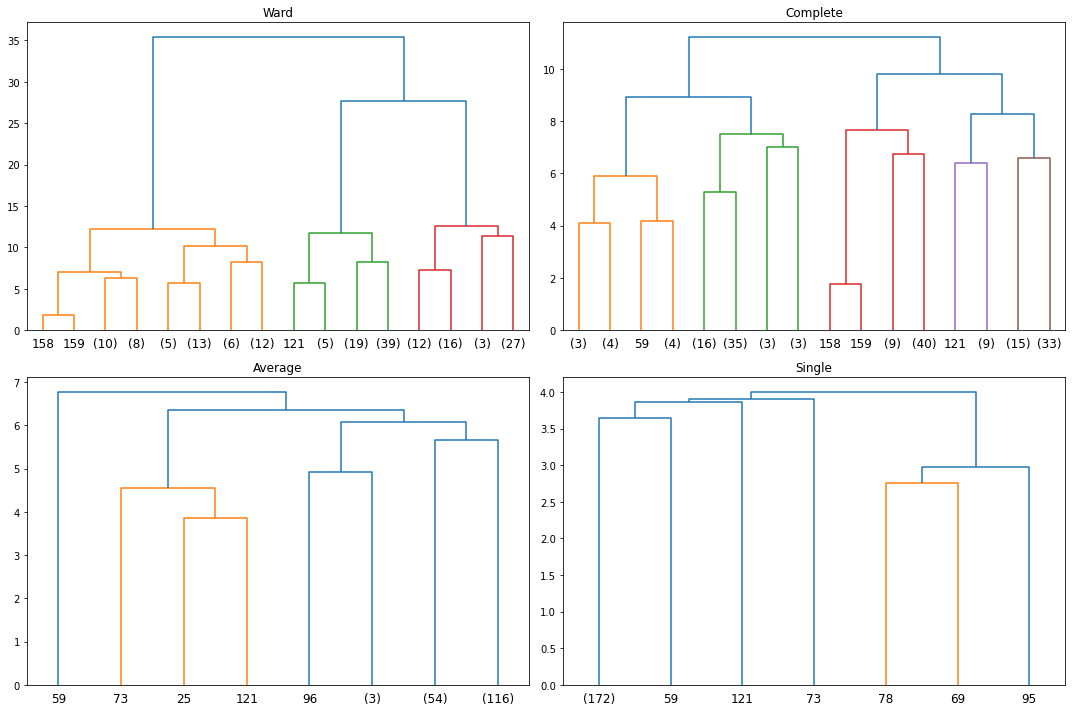

In [8]:
### Compare the different linkages for hierarchical clustering (with dendrogram)

def plot_dendrogram(model, **kwargs): ### base code from https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)



# setting distance_threshold=0 ensures we compute the full tree.
models = [AgglomerativeClustering(distance_threshold=0, n_clusters=None,linkage='ward'),
          AgglomerativeClustering(distance_threshold=0, n_clusters=None,linkage='complete'),
          AgglomerativeClustering(distance_threshold=0, n_clusters=None,linkage='average'),
          AgglomerativeClustering(distance_threshold=0, n_clusters=None,linkage='single')]
names = ['Ward', 'Complete', 'Average', 'Single']

fig, ax = plt.subplots(2, 2, figsize=(15, 10))

for i in range(4):
    model = models[i].fit(data_wine_scaled)
    name = names[i]
    ax[i//2][i%2].set_title(name)
    plot_dendrogram(model, truncate_mode="level", p=3, ax=ax[i//2][i%2])

plt.tight_layout()
plt.show()

100%|██████████| 178/178 [00:02<00:00, 88.79it/s] 


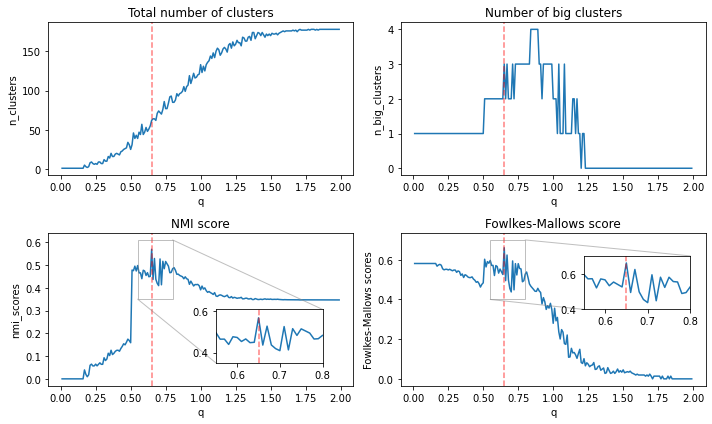

In [9]:
### See effect of the q parameter with fixed p
# ~ 11 minutes to run
p = 1e-6
l_q = np.arange(0.01, 2, 0.01)
l_q_nmi = []
l_q_silhouette = []

n_clusters = []
n_big_clusters = []
nmi_scores = []
fw_scores = []

for q in l_q:
    labels = SVC(data_wine_scaled, p, q)[0]
    n_clusters.append(len(np.unique(labels)))
    n_big_clusters.append(np.sum(np.unique(labels, return_counts = True)[1]>5))
    try: #avoid errors in nmi score (in case of only 1 cluster)
        nmi_scores.append(normalized_mutual_info_score(targets['class'].to_numpy(), labels))
        l_q_nmi.append(q)
    except:
        print('')
    fw_scores.append(fowlkes_mallows_score(targets['class'].to_numpy(), labels))

fix, ax = plt.subplots(2,2,figsize = (10,6))
ax[0][0].plot(l_q, n_clusters)
ax[0][0].set(title = 'Total number of clusters', xlabel = 'q', ylabel = 'n_clusters')


ax[0][1].plot(l_q, n_big_clusters)
ax[0][1].set(title = 'Number of big clusters', xlabel = 'q', ylabel = 'n_big_clusters')

ax[1][0].plot(l_q_nmi, nmi_scores)
ax[1][0].set(title = 'NMI score', xlabel = 'q', ylabel = 'nmi_scores')
axins = ax[1][0].inset_axes([0.55,0.15,0.35,0.35], xlim = (0.55,0.8), ylim = (0.35,0.61))
axins.plot(l_q_nmi, nmi_scores)
axins.axvline(x = 0.65, color = 'red', alpha = 0.5, linestyle = '--')
ax[1][0].indicate_inset_zoom(axins)

ax[1][1].plot(l_q, fw_scores)
ax[1][1].set(title = 'Fowlkes-Mallows score', xlabel = 'q', ylabel = 'Fowlkes-Mallows scores')
axins2 = ax[1][1].inset_axes([0.60,0.50,0.35,0.35], xlim = (0.55,0.8), ylim = (0.40,0.7))
axins2.plot(l_q, fw_scores)
axins2.axvline(x = 0.65, color = 'red', alpha = 0.5, linestyle = '--')
ax[1][1].indicate_inset_zoom(axins2)

for i in range(2):
    for j in range(2):
        ax[i][j].axvline(x = 0.65, color = 'red', alpha = 0.5, linestyle = '--')

plt.tight_layout()
#plt.savefig('C:/Users/gabri/x/4A/Dataset/plot_analysisq_v1.png')
plt.show()